# Sentiment Analysis using BERT


### Import Libraries and Set the intial variables

In [1]:
!pip install transformers


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Load the data

In [5]:
df = pd.read_csv("datasets/depressive_tweets_processed.csv",sep = '|', header = None, usecols = range(0,9))
df.columns = [3, "date", "time", "time-zone", "user", "tweet", 0, 1, 2]
df = df.drop([0, 1, 2, 3, "time-zone", "time", "date", "user"], axis = 1)
df['label'] = [1] * len(df['tweet']) # 1 cause these are all depressed tweets
df2_d = pd.read_csv("datasets/d_tweets.csv")
df2_d = df2_d[["tweet"]]
df2_d['label'] = [1] * len(df2_d['tweet'])

df2_nd = pd.read_csv("datasets/non_d_tweets.csv")
df2_nd = df2_nd[["tweet"]]
df2_nd['label'] = [0] * len(df2_nd['tweet'])
print(len(df2_nd['label']))
df = pd.concat([df2_d, df2_nd, df])
df.reset_index(inplace = True)
df['tweet'] = df['tweet'].astype(str)



4809


In [6]:
p_df = pd.read_csv("datasets/positive_user.csv")
n_df = pd.read_csv("datasets/negative_user.csv")

In [7]:
p_df = p_df.iloc[:50000]
n_df = n_df.iloc[:50000]

In [8]:


df = pd.concat([p_df, n_df])
temp = df.values



grouped = df.groupby('user')['text'].agg(list).reset_index()

# Extract the label for each user (assuming it's the same for all tweets by the same user)
grouped['label'] = df.groupby('user')['label'].first().values

# Rename columns to match your desired structure
grouped.columns = ['user', 'tweet', 'label']

# Create a new DataFrame with the desired structure
df = grouped[['user', 'tweet', 'label']]

# Display or use new_df as needed



We can see that the most relevant column for us is content and replyContent and the score as well.

In [1]:
#df.iloc[4].tweet

In [10]:
# Plot the distribution
class_names = ['not depressed', 'depressed']


## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation.

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word.

In [11]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, force_download=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [12]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [13]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in df.tweet:
    for txt2 in txt:
        tokens = tokenizer.encode(txt, max_length=5000)
        token_lens.append(len(tokens))

txt = df.tweet[3]
print(txt)
for txt2 in txt:
    tokens = tokenizer.encode(txt, max_length=5000)
    print(tokens)
    #token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['RT @heyjenbartel: I see a lot of beginner artists missing the mark on drawing profile views, particularly on eyebrows &amp; eyes—I hope this he…', 'RT @mahoxyshoujo: CRUD I FORGOT THIS ONE\r\n#だりなつ https://t.co/xQHmYs9iZ3', 'RT @asseylumalIusia: I wish yoshino would sit in the chair but a good photo nontheless https://t.co/YN1TPPO3M5', 'RT @Alulora: Well\r\nShe is really\r\nReally pretty https://t.co/KRkYNvGWCO', "RT @nozomistoujo: this is the ultra rare 10 SSR roll. rt for good luck and you'll roll an SSR of your best girl https://t.co/5K78JQndKM", '@Alulora Really? That would be great!', 'RT @Alulora: Daily I REALLY LOVE YOU YOSHINON post https://t.co/jmGjmRWQwk', "@Alulora Thank you!! I'll study English more!", '@Alulora No problem! Please correct my mistakes in English, if any...!', "@Alulora I'm glad. You think so,too!! And thank you for following !", "RT @hoshinamino: Ankle length shoes from my office sans Mio...\r\nI want Anya's shoes......... https://t.co/6dckPGtA00", 'RT @pa

Text(0.5, 0, 'Token count')

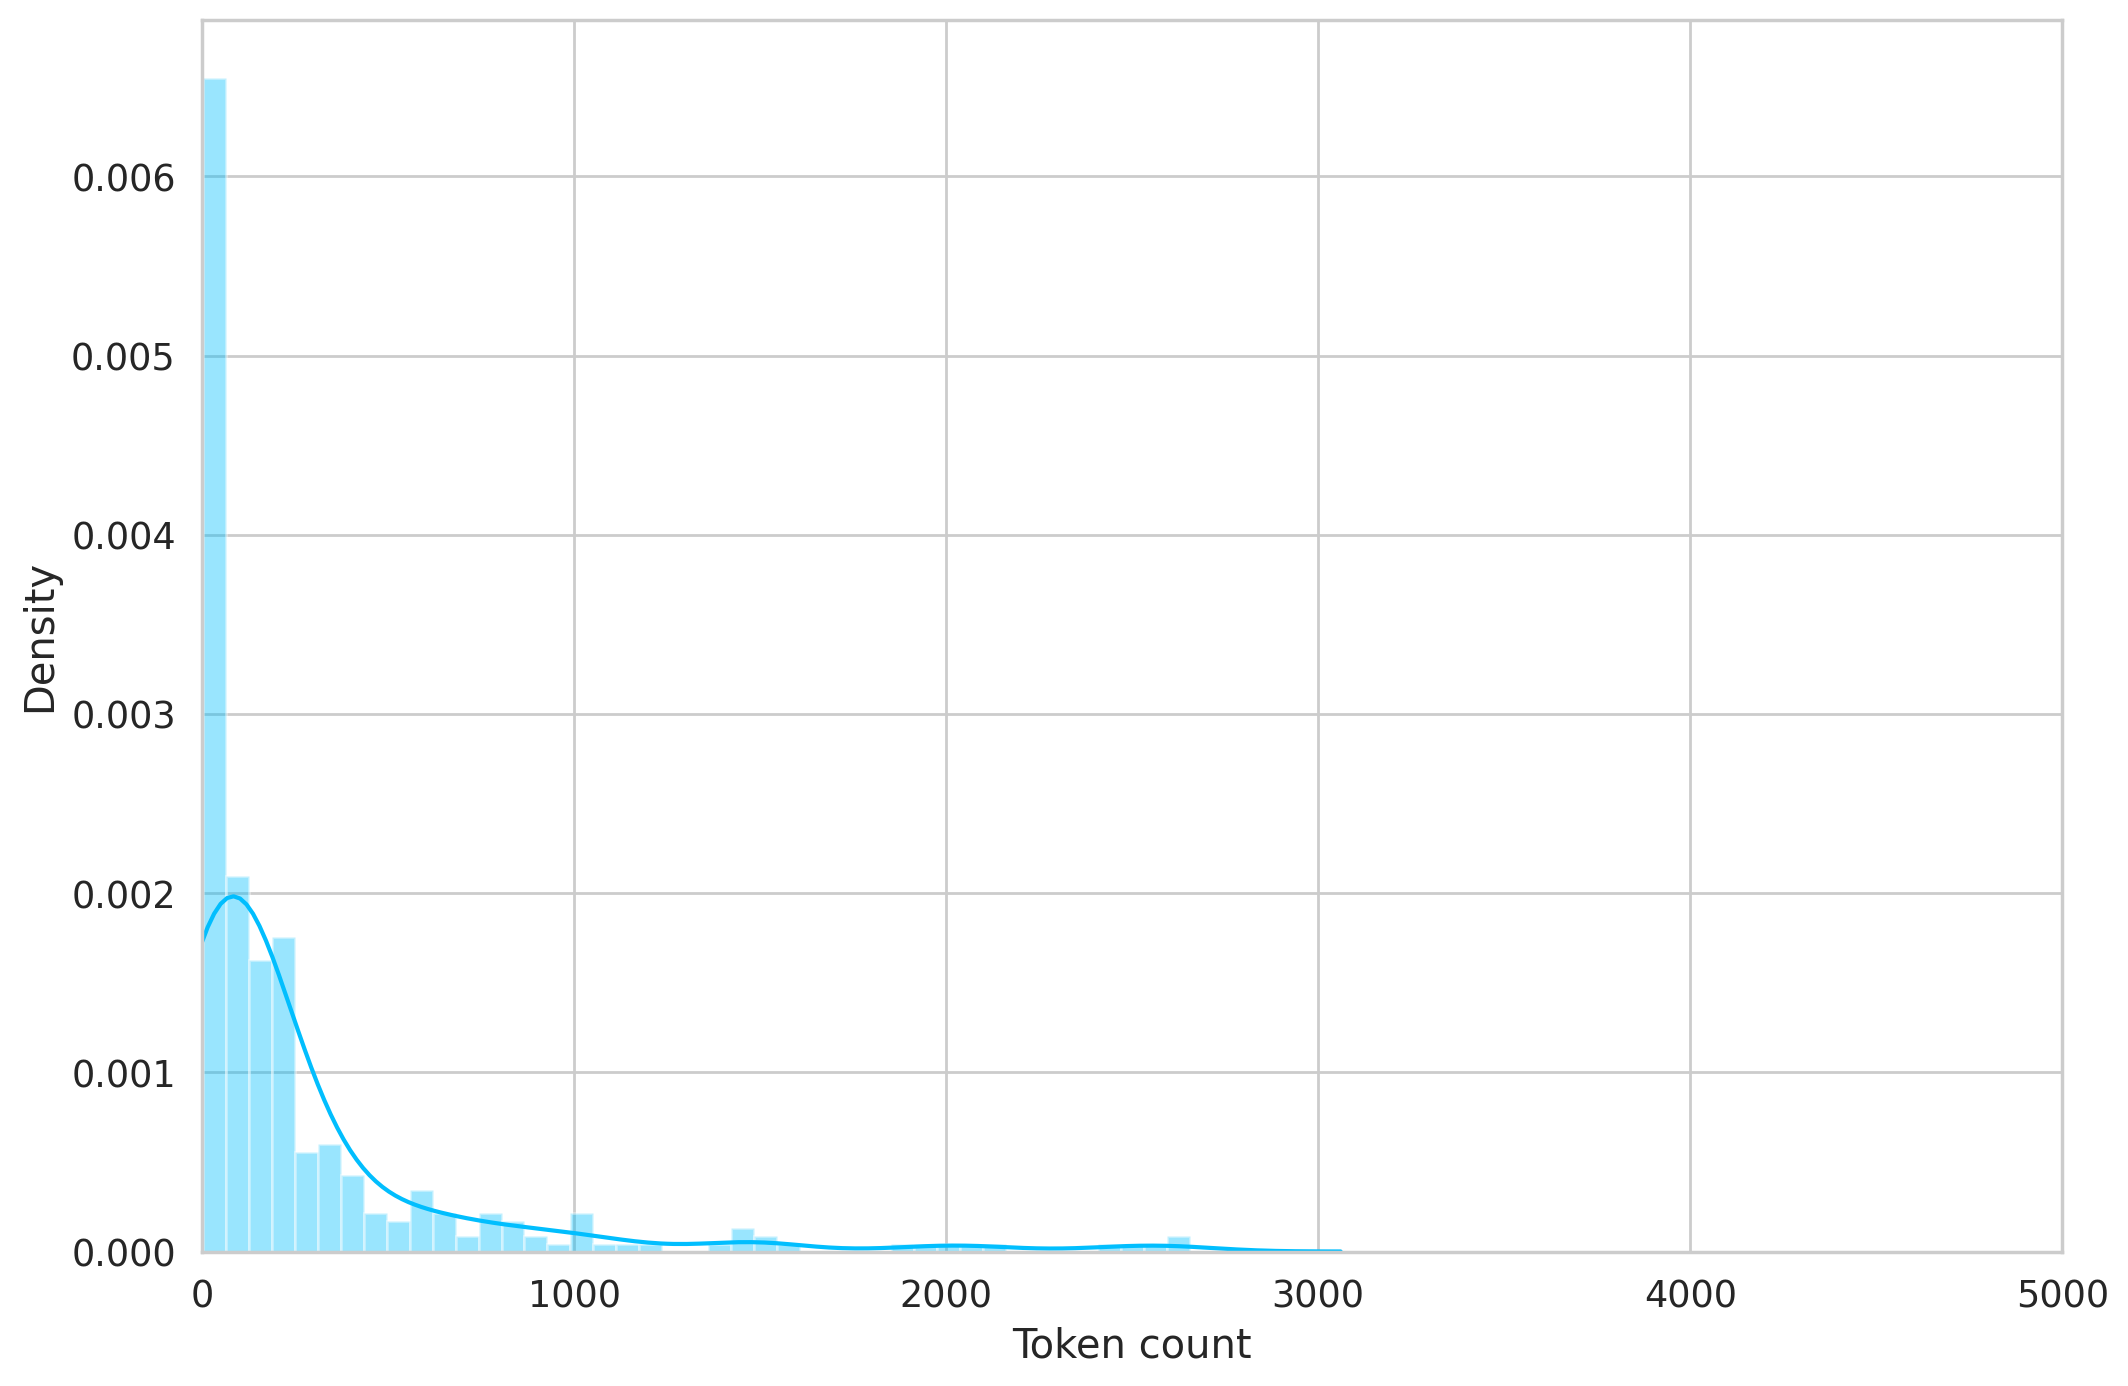

In [23]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 5000]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160.

In [14]:
MAX_TWEETs = 5000
MAX_LEN = 160

In [15]:
tweets = []

for x in df['tweet'].values:
  temp = x
  if len(temp) < MAX_TWEETs:

    temp.extend([""] *( MAX_TWEETs - len(temp) ))

  tweets.append(temp)
df['tweet'] = tweets


### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily.

In [16]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned


        encoding = [self.tokenizer.encode_plus(x,add_special_tokens=True,max_length=self.max_len,return_token_type_ids=False,pad_to_max_length=True,return_attention_mask=True,return_tensors='pt',) for x in review]
        if(len(encoding) > MAX_TWEETs):
          encoding = encoding[0:MAX_TWEETs + 1]


        return {
            'review_text': review,
            'input_ids': [x['input_ids'].flatten() for x in encoding],
            'attention_mask': [x['attention_mask'].flatten() for x in encoding],
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [17]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(303, 3) (38, 3) (38, 3)


Create a dataloader to release data in batches.

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.tweet.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [19]:
# Create train, test and val data loaders
BATCH_SIZE = 1
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())



dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])


In [21]:
print(data['input_ids'][0].shape)
print(data['attention_mask'][0].shape)
print(data['targets'][0].shape)

torch.Size([1, 160])
torch.Size([1, 160])
torch.Size([])


In [39]:
data

{'review_text': ['["i\'m not gonna go through this with you too...", \'RT @ariyanaparker: I HOPE GOOD GIRLS &amp; GOOD GUYS FIND EACH OTHER AND THE FUCKED UP PEOPLE JUST STAY TOGETHER LIKE QUIT HURTING GOOD ASS PEO…\', "RT @emgeeeezy: Idk why I keep caring about you after you stopped giving a fuck about me a long time ago guess that\'s jut the kinda person I…", \'RT @SexualGif: if ur a girl, pls read https://t.co/wvMHLEIGhd\', \'RT @wylancabuag: we are https://t.co/Ig85R129Hc\', \'RT @ohhcami_: My mom told me.. "a person who values u wouldn\\\'t ever put themselves in a position to lose u" and that really hit deep\', \'RT @BriaRonae: He gets it. https://t.co/iuIvxWdoD1\', \'RT @keola_paredes: #HawaiiKidProblems\\r\\n\\r\\nCollege friends: So did you fly here?\\r\\n\\r\\nMe: Nah fam https://t.co/YsHl58X7nz\', \'RT @GawdTrill: Shit gets old. You get tired of trying to work things out. You get tired of giving chances. Sometimes you just have to let p…\', \'@JordanWeall lol not just one, b

## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [22]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [23]:
t = torch.Tensor([1, 2, 3])
out = t.cpu().detach().numpy()

In [32]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(input_size=768, hidden_size=50, num_layers=1, batch_first=True)
        self.out = nn.Linear(self.lstm.hidden_size, 1)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
      pooled_output = np.empty((MAX_TWEETs + 1, BATCH_SIZE, MAX_LEN, 768))
      for x in range(0 , len(input_ids)):
        output = self.bert(input_ids=input_ids[x],attention_mask=attention_mask[x],return_dict=False)
        output = self.drop(output[0])
        pooled_output[x] = output.cpu().detach().numpy()
      pooled_output = np.float32(pooled_output)
      lstmOut = self.lstm(torch.from_numpy(pooled_output.reshape(BATCH_SIZE*MAX_LEN, MAX_TWEETs + 1, 768)).cuda())
      realLSTMOut = np.empty((BATCH_SIZE, 50))
      lstmOut = lstmOut[0].cpu().detach()
      for i in range(0, BATCH_SIZE):
        realLSTMOut[i] = lstmOut[i][MAX_TWEETs]
      realLSTMOut = np.float32(realLSTMOut)
      linear = self.out(torch.from_numpy(realLSTMOut).cuda())
      return torch.sigmoid(linear)


We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [33]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [34]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [35]:
# Number of iterations
EPOCHS = 4

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.BCELoss().to(device)

In [28]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, progress_bar=None):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = [x.to(device) for x in d["input_ids"]]
        attention_mask = [x.to(device) for x in d["attention_mask"]]
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        outputs = torch.reshape(outputs, (-1, 1)).float()
        targets = torch.reshape(targets, (-1, 1)).float()

        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(outputs == targets)
        losses.append(loss.item())
        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if progress_bar:
            progress_bar.update(1)
        
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples, progress_bar=None):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            outputs = torch.reshape(outputs, (-1, 1)).float()
            targets = torch.reshape(targets, (-1, 1)).float()

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(outputs == targets)
            losses.append(loss.item())
            print("it")

    
            if progress_bar:
                progress_bar.update(1)
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [30]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [31]:
%%time


from tqdm import tqdm

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    
    train_progress_bar = tqdm(total=len(train_data_loader), desc="Training", position=0, leave=True)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        train_progress_bar
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    
    val_progress_bar = tqdm(total=len(val_data_loader), desc="Validation", position=0, leave=True)

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        val_progress_bar
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/4
----------


Training:   1%|▏                              | 2/303 [01:45<4:26:41, 53.16s/it]

KeyboardInterrupt: 

In [88]:
df

,user,tweet,label
0,0010010i,[RT @sgak_______: .\r\n\r\n⌇news / shigeaki❄️💧...,1
1,0111_i_,[RT @yoooon_g_170111: 아이(I) 1st Mini Album [I ...,1
2,0925z0112,[RT @justinbieber: My sister has a YouTube cha...,1
3,0I1I1I0,[RT @heyjenbartel: I see a lot of beginner art...,1
4,0White_prayer0,[@_yuiseru lmfao let me match one with my oc t...,1
...,...,...,...
374,beatrice_kaylee,"[Skip school lets start fall break, RT @chanel...",1
375,beautyofbulimia,"[I'll just lie awake till 3AM, crying, hoping ...",1
376,beayngo,"[i'm going crazy here, i need to talk to someo...",1
377,beck_eeee87,[@HumanServicesAU im not required to work. I a...,1


The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

In [ ]:
history

defaultdict(list, {})

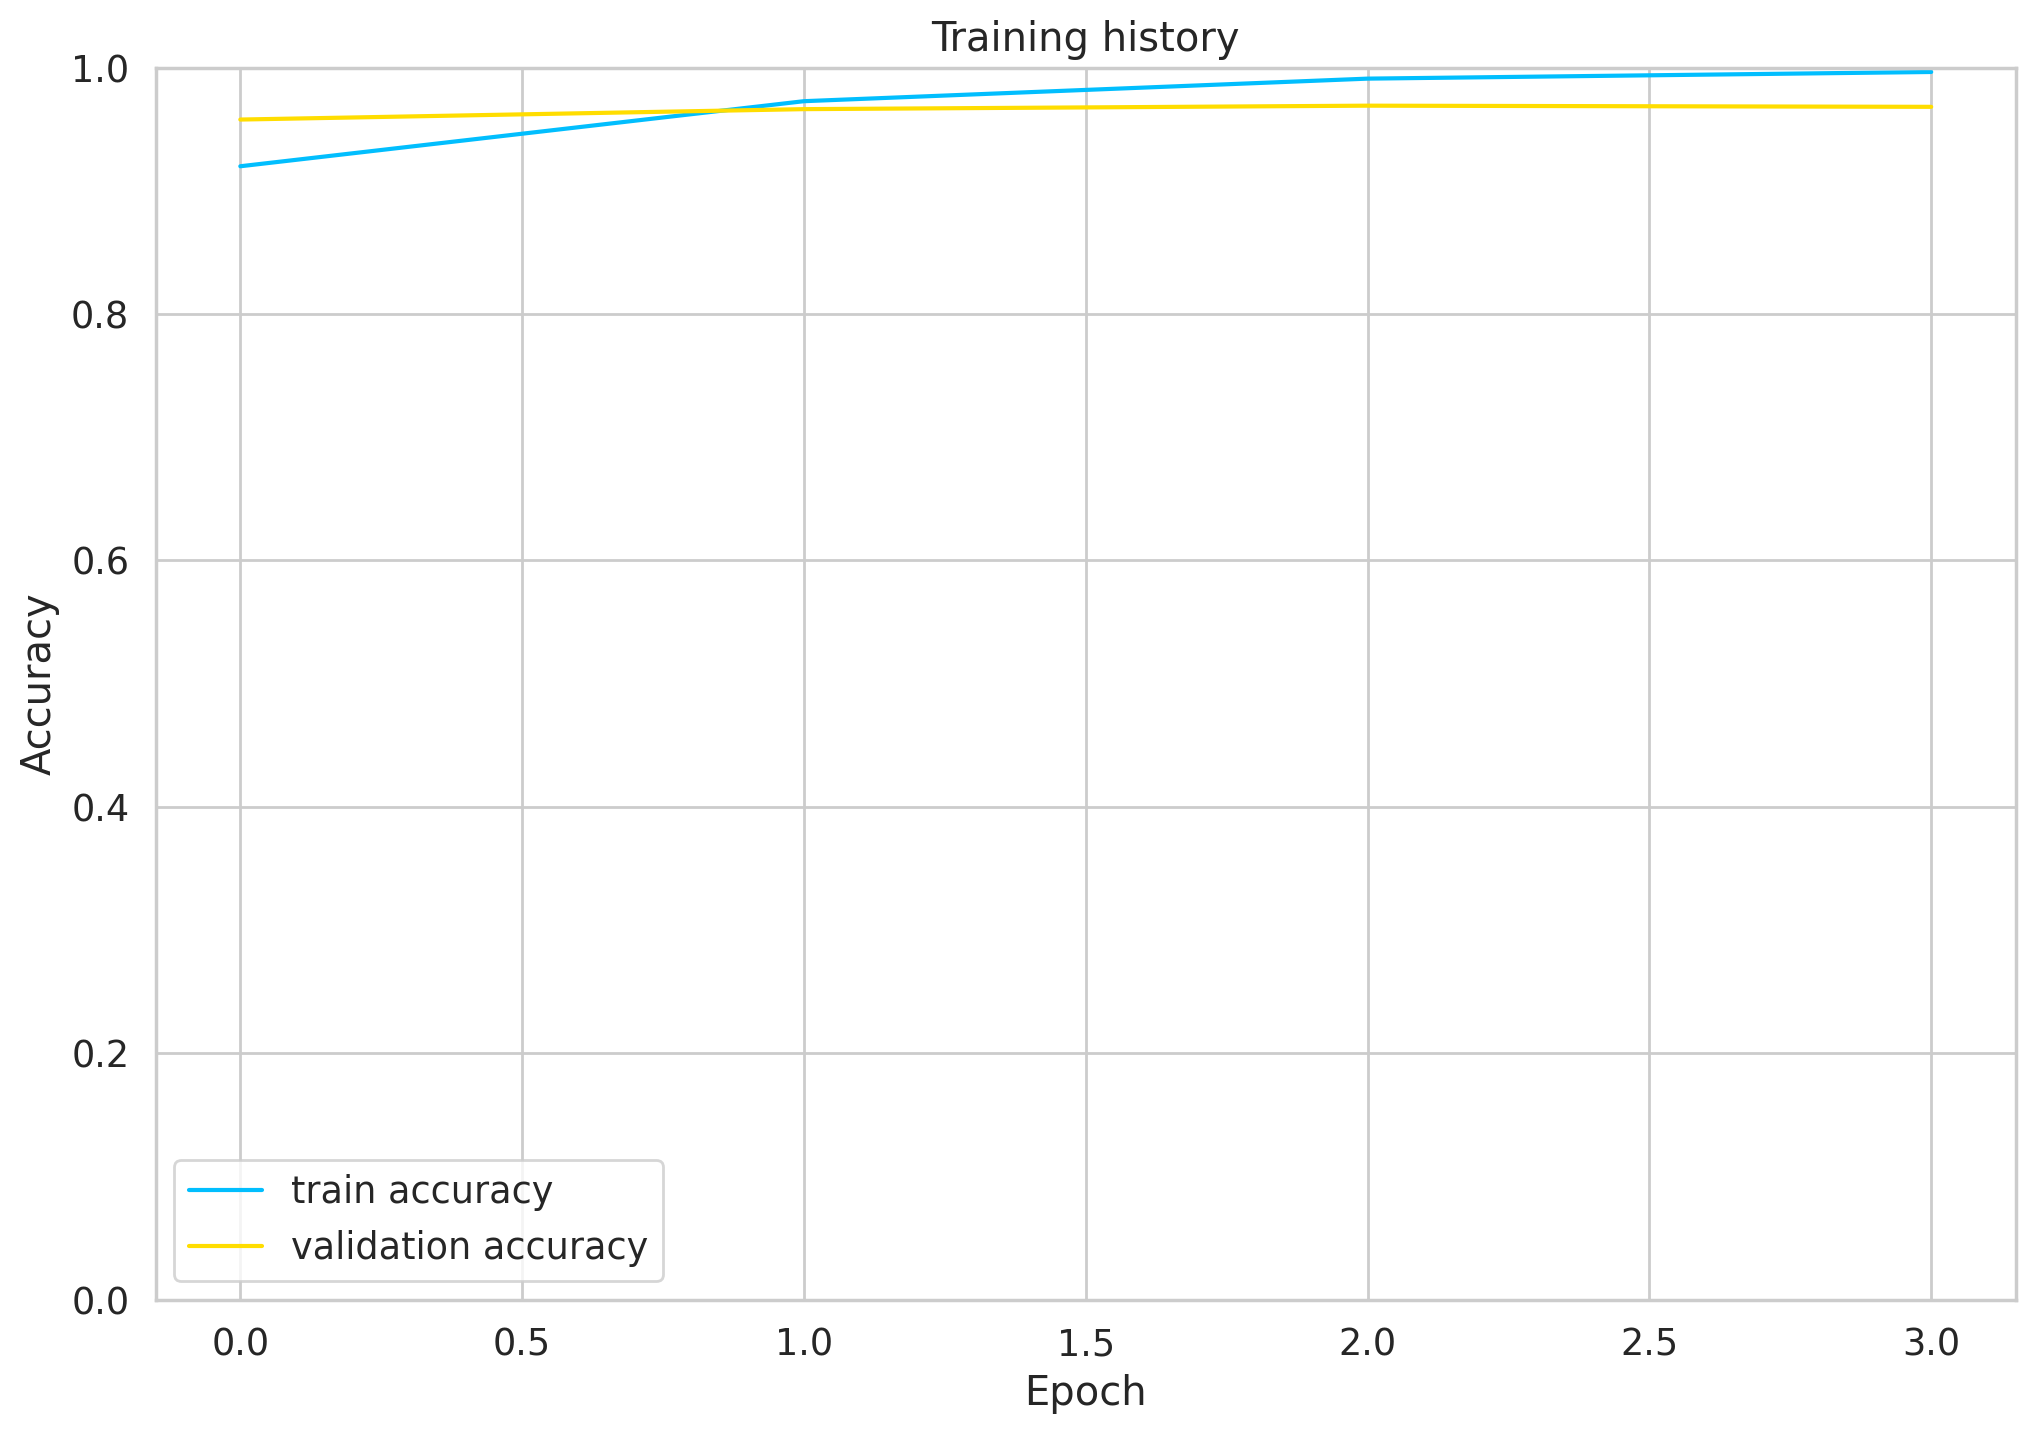

In [ ]:
# Plot training and validation accuracy
plt.plot(list(map(lambda x: x.cpu(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.cpu(), history['val_acc'])), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9605633802816902

In [ ]:
Ones = 0
Zeros = 0
test
for x in test_data_loader.dataset.targets:
  if x ==0:
    Zeros+=1
  else:
    Ones+=1
print("0", Zeros, "1", Ones)

0 470 1 595


In [ ]:
test_data_loader.dataset.targets

array([1, 1, 1, ..., 0, 0, 0])

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.95      0.96      0.96       470
    depressed       0.97      0.96      0.96       595

     accuracy                           0.96      1065
    macro avg       0.96      0.96      0.96      1065
 weighted avg       0.96      0.96      0.96      1065



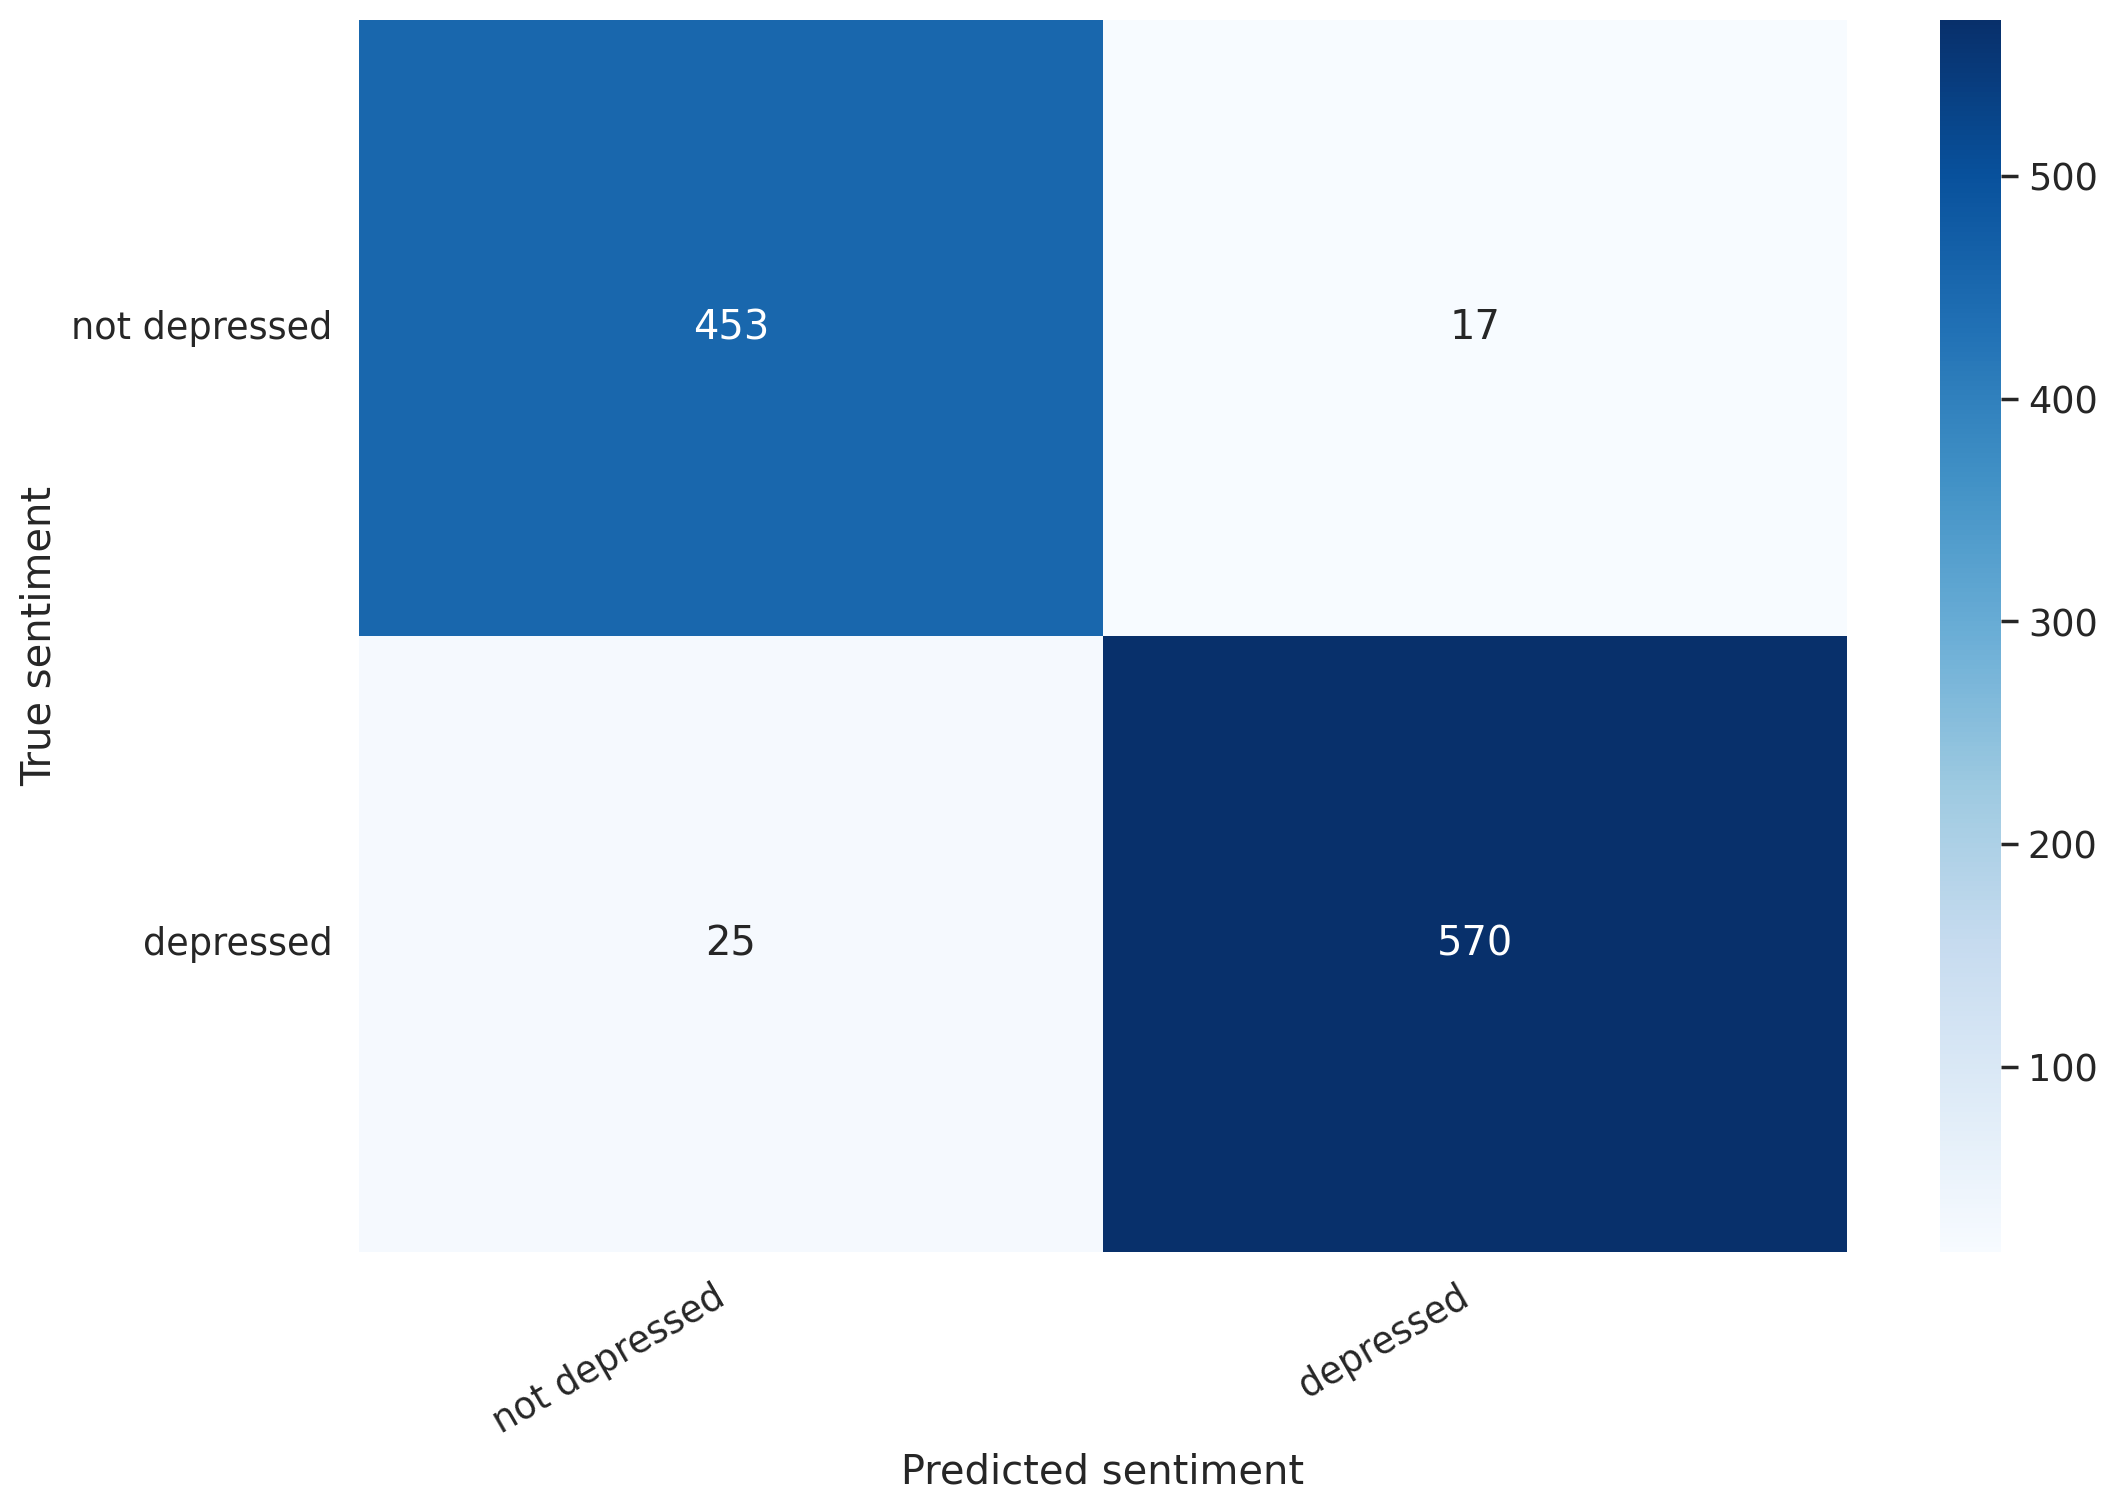

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [ ]:
review_text = "I have depression h"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I have depression sadly
Sentiment  : depressed


In [ ]:
torch.save(model.state_dict(), "model.pt")

In [ ]:
model = torch.load("model.pt", map_location=torch.device('cpu'))

print(type(model))

<class 'collections.OrderedDict'>


In [ ]:

model = SentimentClassifier(len(class_names))
model.load_state_dict(test)



<All keys matched successfully>